**References**:

[R1] - [SMAP Ancilliary Data Product](https://nsidc.org/sites/default/files/smap_anc_l1l3l4.pdf)   
[R2] - [SMAP Spacecraft Frames Definition Kernel](https://naif.jpl.nasa.gov/pub/naif/SMAP/kernels/fk/smap_pf_v14.tf)   
[R3] - [SMAP L1b Product Specification Document](https://nsidc.org/sites/default/files/smap_radiometer_level_1b_tb_product20specification20document_1805b15d.pdf)

**Data**:

[D1] - [SMAP Antenna Patterns](https://urs.earthdata.nasa.gov/oauth/authorize?client_id=_JLuwMHxb2xX6NwYTb4dRA&response_type=code&redirect_uri=https%3A%2F%2Fn5eil01u.ecs.nsidc.org%2FOPS%2Fredirect&state=aHR0cHM6Ly9uNWVpbDAxdS5lY3MubnNpZGMub3JnL1NNQVBfQU5DL1NNQVBfTDFfTDNfQU5DX1NUQVRJQy4wMDEvMjAxNi4xMi4wNy9SYWRpb21ldGVyQW50UGF0dGVybl8xNzA4MzBfdjAxMS5oNQ)  
[D2] - [SMAP L1b File](https://urs.earthdata.nasa.gov/oauth/authorize?client_id=_JLuwMHxb2xX6NwYTb4dRA&redirect_uri=https%3A%2F%2Fn5eil01u.ecs.nsidc.org%2FOPS%2Fredirect&response_type=code&state=aHR0cHM6Ly9uNWVpbDAxdS5lY3MubnNpZGMub3JnL0RQNC9TTUFQL1NQTDFCVEIuMDA1LzIwMjMuMTIuMDEvU01BUF9MMUJfVEJfNDcxODVfRF8yMDIzMTIwMVQyMTIxMjBfUjE4MjkwXzAwMS5oNQ)

# **Step 1 - Opening and interpretating the Antenna Patterns**

We begin with the SMAP Antenna Patterns. They are in HDF5 format and can be downloaded from [D1]. The only resource describing the file is in [R1], at the end of page 6. The patterns are provided in a spherical coordinate system, with a 0.1&deg; resolution and [0&deg;<=&phi;<=360&deg;], [0&deg;<=&theta;<=180&deg;].

![Spherical Coordinate System](Images/spherical_coordinate_system.png)

The following code block opens and inspects the Antenna Patterns.

In [1]:
import h5py
import numpy as np 
from pyproj import CRS, Transformer
import matplotlib.pyplot as plt

antenna_file_path = '/home/beywood/ST/CIMR_RGB/CIMR-RGB/dpr/Antenna_patterns/SMAP/RadiometerAntPattern_170830_v011.h5'

# Open and Extract Data
with h5py.File(antenna_file_path, 'r') as f:
    gains = f['Gain']
    phi = np.deg2rad(f['Grid']['phi'][:])
    theta = np.deg2rad(f['Grid']['theta'][:])

    gain_dict = {}
    for i in gains:
        gain_dict[i] = gains[i][:]
        

def normalise_gains(gain_dict):
    for gain in gain_dict:
        linear_values = 10**(gain_dict[gain]/10)
        normalised_values = linear_values/np.max(linear_values)
        gain_dict[gain] = normalised_values

# Run the following line if you want to linearise and normalise the Gains
# gain_dict = normalise_gains(gain_dict)

# Note: for the gain arrays, the rows represent phi and the columns theta. 


For the rest of the notebook, we will just consider a single component of the antenna pattern, "G1h". The first step in the transformation is to convert from a sperical coordinate system to a cartesian coordinate system using the following formulae. 

\begin{equation}
x = \sin(\theta)\cos(\phi)
\end{equation}
\begin{equation}
y = \sin(\theta)\sin(\phi)
\end{equation}
\begin{equation}
z = \cos(\phi)
\end{equation}

It's useful at this stage to insepct the data to get a feel for the Antenna patterns. The code below provides some functions for making polar and 3D plots. 

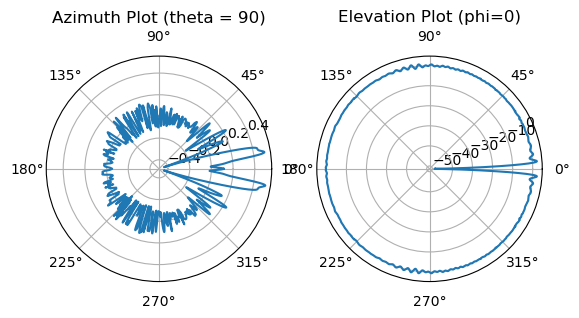

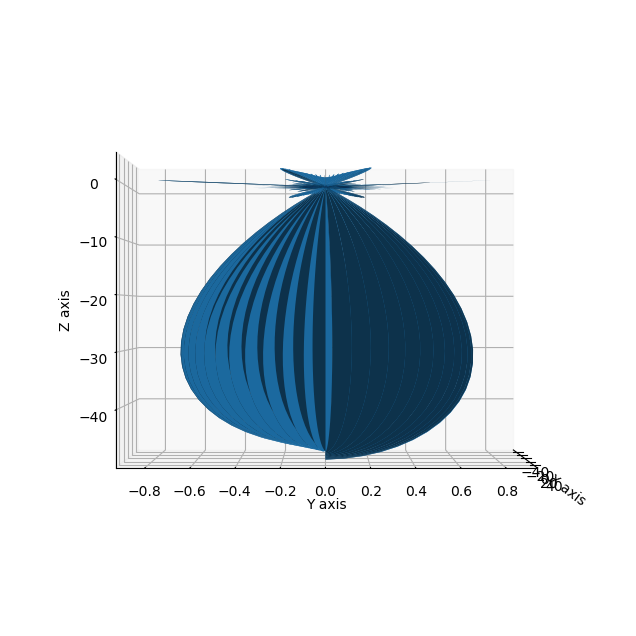

In [2]:
# Change key to inspect different Antenna pattern components. Your options are 'G1v', 'G2v', 'G3v', 'G4v', 'G1h', 'G2h', 'G3h', 'G4h'.
# Check [R1] for what they mean .
gain = gain_dict['G1h']

# Create a grid from the 1D coordinate arrays. 
theta_grid, phi_grid = np.meshgrid(theta, phi)

#----------------------------------------------------------------------------
# View the polar plots of the patterns. 
# You should around with fixed_phi and fixed_theta. Referring to spherical coordinate system image above. 
 
fixed_phi = int(0) # in degrees, between 0-360
fixed_theta = int(90) # in degreess, between 0-180

# Convert input angle to array index
phi_index = fixed_phi*10
theta_index = fixed_theta*10

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'})

# Create "Azimuth Plot", where theta is fixed. 
azimuth_gains = gain[:, theta_index]
ax1.plot(phi, azimuth_gains)
ax1.set_title(f'Azimuth Plot (theta = {fixed_theta})')

# Create "Elevation Plot, where phi is fixed. 
# We mirror theta as we only have data from 0-180. 
elevation_gains = gain[phi_index, :]
elevation_gains_full = np.concatenate((elevation_gains, elevation_gains[::-1]))
theta_full = np.concatenate((theta, theta + np.pi))
ax2.plot(theta_full, elevation_gains_full)
ax2.set_title(f'Elevation Plot (phi={fixed_phi})')

#-----------------------------------------------------------------------------
# Conversion to Cartesian Coordinates
# Note: For the coordainte conversion later on, you actually don't need to include the 'gain' in this equation as you are only
# interested in the "direction" of the vector. 
x = gain*np.sin(phi_grid)*np.cos(theta_grid)
y = gain*np.sin(phi_grid)*np.sin(theta_grid)
z = gain*np.cos(theta)

#----------------------------------------------------------------------------
# Make a 3D surface plot of the pattern. 
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1, projection='3d')
surf = ax.plot_surface(x, y, z)  # , alpha=0.5, zorder = 0.5)
# fig.colorbar(surf)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
# Change these values to view the pattern from different planes/orientations
ax.view_init(elev=0, azim=0)
plt.show()
#----------------------------------------------------------------------------

The final step before the coordinate trnasformation is to cut the antenna patterns down. We don't need the gains behaind or two the sides, only in the region of maximum gain. After playing around with the whole pipeline (a.k.a projecting every point to the Earth), which I would reccomend you to try, I figure out that we want to make a "cone" around the maximum directivity in the elevation plane. 

In other words, this means keeping the full range of &phi;, while trimming the &theta; range to +/-5&deg; (see elevation plot). In any case, I encourage you to play around with these values to see the effect on the Earths surface. 

The method projects the Antenna pattern on the Earth and it looks like a circle around the boresight. If you change increase &theta;, the circle gets bigger. If you reduce &phi;, you only plot part of the circle (i.e if you reduce to 180 degree range, you only plot half the circle on the Earth). 

In [9]:
# Cut down the range of Antenna Pattern to plot on the surface. 
# Change the range of angles you want to transform based on the spherical coordainte system. 
phi_range = np.deg2rad(360)
theta_range = np.deg2rad(5)

# Reduce arrays based on inputs (referring to the spherical coordiante system above).
theta_indices = np.where((theta <= 0 + theta_range))[0]

phi_indices_1 = np.where((phi >= 0) & (phi <= phi_range))[0]
phi_indices_2 = np.where((phi >= 2*np.pi - phi_range))[0]
phi_indices = np.concatenate((phi_indices_1, phi_indices_2))

# We re-define the arrays based on the subset. 
reduced_gain_array = gain[phi_indices, :][:, theta_indices]
theta_grid, phi_grid = np.meshgrid(theta[theta_indices], phi[phi_indices])
x = np.sin(theta_grid)*np.cos(phi_grid) # As discussed above, we don't need to multiply by gain. 
y = np.sin(theta_grid)*np.sin(phi_grid)
z = np.cos(theta_grid)


# These should all be the same shape.
print(reduced_gain_array.shape)
print(theta_grid.shape)
print(phi_grid.shape)
print(x.shape)
print(y.shape)
print(z.shape)

print(x)




(7202, 51)
(7202, 51)
(7202, 51)
(7202, 51)
(7202, 51)
(7202, 51)
[[0.         0.00174533 0.00349065 ... 0.08367784 0.08541692 0.08715574]
 [0.         0.00174533 0.00349065 ... 0.08367772 0.08541679 0.0871556 ]
 [0.         0.00174532 0.00349063 ... 0.08367734 0.0854164  0.08715521]
 ...
 [0.         0.00174532 0.00349063 ... 0.08367734 0.0854164  0.08715521]
 [0.         0.00174533 0.00349065 ... 0.08367772 0.08541679 0.0871556 ]
 [0.         0.00174533 0.00349065 ... 0.08367784 0.08541692 0.08715574]]


# **Step 2 - Converting the patterns to the appropriate reference frame**

The following method is based on the detailed study of [R2]. The file is a standard file used in SPICE, a NASA toolbox for all things orbits. However, it gives some crucial information for the frame definitions and transfers. Before continuing this step, I also encourage you to read [R3] Section 3.1, which gives a further overview of the frames and coordiante systems used. 

**Note**: There is a document referenced in [R2] called '4.   SMAP Pointing, Positioning, Phasing & Coordinate Systems,
        Volume 0, May 18, 2010'. I have contacted the NASA archives for this document and unfortunately it is not available for public release. 

**I assume that the positive Z-axis of the antenna patterns aligns with the positive Z-axis of the SMAP Antenna Beam Frame (SMAP_ANT_BEAM)**. For the X and Y-axis of the Antenna Patterns, I don't think it matters how they are alligned relative to SMAP_ANT_BEAM, so I don't consider it further. 

The first transformation is from the SMAP_ANT_BEAM frame to the 'SMAP Instrument Rotating Frame (SMAP_INSR)'. This involves a single rotation about of the +Z axis about Y of 144.54 &deg;.

The rotation matrix for this is as follows: 

\begin{equation}
R_y(\theta) = \begin{pmatrix}
\cos\theta & 0 & \sin\theta \\
0 & 1 & 0 \\
-\sin\theta & 0 & \cos\theta
\end{pmatrix}
\end{equation}



In [10]:
# Transforming the antenna patterns from ANT_BEAM to INSR frame
ant2insr_rot_angle = np.deg2rad(144.54)
ant2insr_rot_mat = np.array([[np.cos(ant2insr_rot_angle), 0, np.sin(ant2insr_rot_angle)],
                                [0, 1, 0],
                                [-np.sin(ant2insr_rot_angle), 0, np.cos(ant2insr_rot_angle)]])

coords_cartesian = np.vstack((x.flatten(), y.flatten(), z.flatten()))
coords_insr = ant2insr_rot_mat @ coords_cartesian

Next, we need to convert from the SMAP_INSR frame to the 'SMAP Instrument Fixed Frame (SMAP_INSF)'. As you will read in [R2], this is a single **counter-clockwise** rotation of the &theta;=scan_angle+180 about the Z-axis. The rotation matrix for this is as follows: 


\begin{equation}
R(\theta) = \begin{bmatrix}
\cos(\theta) & -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1
\end{bmatrix}
\end{equation}

In [11]:
# Transforming patterns from INSR frame to INSF frame. 
scan_angle = np.deg2rad(271.35852) # This is the first data point from the L1b file. This is described later. 
theta = scan_angle + np.deg2rad(180)
insr2insf_rot_mat = np.array([[np.cos(theta), -np.sin(theta) , 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])

coords_insf = insr2insf_rot_mat @ coords_insr

The next step is to go from the INSF frame to the 'Spacecraft Frame (SMAP_SC)'. The INSF frame is defined as a fixed offset relative to the SMAP_SC frame. 

**Note: This offset is apparantly included in the values of roll, pitch and yaw from the L1b file, so if/when we implement the values of roll, pitch and yaw, I think we should remove the following transformations. See [R3], Section 3.2**

It is stated in [R2] that 'the SMAP_INSF frame was determined to be rotated from the SMAP_SC frame first by -0.021 degrees about Y, then by -0.072  degrees about X.'

So in order to go from the INSF frame back to the SC frame, I interpret this as needing first a rotation of 0.072 degrees about X, followed by a 0.021 degree rotation about Y. The rotation matricies are as follows:


\begin{equation}
R_X(\theta_X) = 
\begin{pmatrix}
1 & 0 & 0 \\
0 & \cos(\theta_X) & -\sin(\theta_X) \\
0 & \sin(\theta_X) & \cos(\theta_X)
\end{pmatrix}
\end{equation}

\begin{equation}
R_Y(\theta_Y) = 
\begin{pmatrix}
\cos(\theta_Y) & 0 & \sin(\theta_Y) \\
0 & 1 & 0 \\
-\sin(\theta_Y) & 0 & \cos(\theta_Y)
\end{pmatrix}
\end{equation}

and the combined matrix. 

\begin{equation}
R_{\text{total}} = R_Y(\theta_Y) \times R_X(\theta_X)
\end{equation}


In [12]:
# Transformation from INSF to SC
theta_x = 0.072
theta_y = 0.021

sc_rot_mat_x = np.array([[1, 0 ,0],
                            [0, np.cos(theta_x), -np.sin(theta_x)],
                            [0, np.sin(theta_x), np.cos(theta_x)]])
sc_rot_mat_y = np.array([[np.cos(theta_y), 0, np.sin(theta_y)],
                          [0, 1, 0],
                          [-np.sin(theta_y), 0, np.cos(theta_y)]])

sc_rot_mat_combined = sc_rot_mat_y @ sc_rot_mat_x
coords_sc = sc_rot_mat_combined @ coords_insf

**Note: Before we project to Earth, I think we still need to implement the roll, pitch and yaw transformation, a description of how to do this is provdided in [R3] Section 3.2. I am still a little bit confused about it, as well as what frame the satellite positional information in the L1b file is provided in (i.e x_pos, y_pos, z_pos from the SMAP L1b.**

In order to project to Earth (as well as validate our results), we need some data from the L1b file. Download the L1b file in [D2] (or any other L1b file of your choice). I just use the first data point in L1b the file for analysis. Just comment and uncomment the values you want to look at. 

In [13]:
l1b_file_path = '/home/beywood/ST/CIMR_RGB/CIMR-RGB/dpr/L1B/SMAP/SMAP_L1B_TB_47185_D_20231201T212120_R18290_001.h5'

def get_l1b_data(l1b_file):
    with h5py.File(l1b_file, 'r') as data:
        spacecraft = data['Spacecraft_Data']
        measurement = data['Brightness_Temperature']
        x_pos = spacecraft['x_pos'][:]
        # bt_h = measurement['tb_h'][:]
        # footprints_per_scan = spacecraft['footprints_per_scan'][:]
        # tbs_per_scan = spacecraft['tbs_per_scan'][:]
        # sc_geodetic_alt_ellipsoid = spacecraft['sc_geodetic_alt_ellipsoid'][:]
        scan_angle = measurement['antenna_scan_angle'][:]
        # pitch = spacecraft['pitch'][:]
        # roll = spacecraft['roll'][:]
        # yaw = spacecraft['yaw'][:]
        y_pos = spacecraft['y_pos'][:]
        z_pos = spacecraft['z_pos'][:]
        sc_nadir_lon = spacecraft['sc_nadir_lon'][:]
        sc_nadir_lat = spacecraft['sc_nadir_lat'][:]
        tb_lat = measurement['tb_lat'][:]
        tb_lon = measurement['tb_lon'][:]
    return x_pos, y_pos, z_pos, scan_angle, sc_nadir_lon, sc_nadir_lat, tb_lat, tb_lon
    
x_pos, y_pos, z_pos, scan_angle, sc_nadir_lon, sc_nadir_lat, tb_lat, tb_lon = get_l1b_data(l1b_file_path)  

print(f"x_pos = {x_pos[0]}")
print(f"y_pos = {y_pos[0]}")
print(f"z_pos = {z_pos[0]}")
print(f"scan_angle = {scan_angle[0][0]}")

x_pos = -299311.375
y_pos = -1201489.0
z_pos = 6942604.5
scan_angle = 271.3585205078125


# **Step 3 - Projecting the Pattern to Earth**

Now we project the pattern to Earth for a given satellite position. As I said previously, I assume that the x_pos, y_pos and z_pos from the l1b file provides the position fro the center of the Earth to the origin of the SC_FRAME, however I am not sure about this. For the following analysis, we just use the first data point from the l1b data. 

In order to obtain obtain the intersection of a line pointing from the origin of the SMAP_SC frame, in a particular direction which is goverened by the location/position/coordinate in the antenna pattern, and the surface of the Earth. We do this by first obtaining the direction vector using norm and then making the equation of this line equal to the equation of the Earths surface and solving using the quadratic formula. As the quadratic formula gives two solutions (one for entry into the Earth and one for exit), you want to take smallest positive solution. 

**Note: If you dont trim the original patterns down enough you will get funny solutions, as many of the lines will not intersect with the suface of the Earth, you should however still be able to plot them on the plotting function later on.**

The equation for an ellipsoid is: 

\begin{equation}
\frac{x^2}{a^2} + \frac{y^2}{b^2} + \frac{z^2}{c^2} = 1
\end{equation}

where I use the following constants for the WGS84 definition of the Earth. 
\begin{equation}
\begin{aligned}
a &= 6378137 \\
b&=c=6356752.314245
\end{aligned}
\end{equation}

The equation of a line in 3D space is:

\begin{equation}
\begin{aligned}
x &= x_0 + d_{x}t \\
y &= y_0 + d_{y}t \\
z &= z_0 + d_{z}t
\end{aligned}
\end{equation}

where $d_{x}$, $d_{y}$ and $d_{z}$ are from the antenna_direction vector defined below.

If you make these two equations equal to one another and do some moving around, you will get the following quadratic equation: 



\begin{equation}
At^2 + Bt + C = 0
\end{equation}


where:


\begin{aligned}
A &= \frac{d_{x}^{2}}{a^{2}} + \frac{d_{y}^{2}}{a^{2}} + \frac{d_{z}^{2}}{b^{2}} \\
B &= \frac{2x_0d_{x}}{a^{2}} + \frac{2y_0d_{y}}{a^{2}} + \frac{2z_0d_{z}}{b^{2}} \\
C &= \frac{x_0^2}{a^2} + \frac{y_0^2}{b^2} + \frac{z_0^2}{c^2} - 1
\end{aligned}

You then substitute the correct solution back into the line equation to obtain the position on the surface in ECEF coordinates, and finally transform these to wgs84 coordinates. 

In [14]:
# Antenna direction vectors
antenna_direction = np.vstack((coords_sc[0,:], coords_sc[1,:], coords_sc[2,:]))
antenna_direction /= np.linalg.norm(antenna_direction, axis=0)

# Ellipsoid parameters
a=6378137
b=6356752.314245

# Satellite position 
x_pos_sat = x_pos[0] # From L1b file
y_pos_sat = y_pos[0]
z_pos_sat = z_pos[0]

# Quadratic Equation co-efficients as defined above.
A = antenna_direction[0]**2/a**2 + antenna_direction[1]**2/a**2 + antenna_direction[2]**2/b**2
B = 2*(x_pos_sat*antenna_direction[0]/a**2 + y_pos_sat*antenna_direction[1]/a**2 + z_pos_sat*antenna_direction[2]/b**2)
C = x_pos_sat**2/a**2 + y_pos_sat**2/a**2 + z_pos_sat**2/b**2 - 1

# Find two solutions 
t1 = (-B + np.sqrt(B**2 - 4*A*C))/(2*A)
t2 = (-B - np.sqrt(B**2 - 4*A*C))/(2*A)

# Choose correct solution
t = np.zeros((t1.shape))
for i in range(len(t1)):
    if np.isnan(t1[i]) and np.isnan(t2[i]):
        t[i] = np.nan
        continue
    if t1[i]>0 and t2[i]>0:
        t[i] = min(t1[i], t2[i])
    elif t1[i]>0:
        t[i] = t1[i]
    elif t2[i]>0:
        t[i] = t2[i]
    elif t1[i] < 0 and t2[i] < 0:
        t[i] = np.nan

# Substitute solution back into line equation
intersection_x = x_pos_sat + t*antenna_direction[0,:]
intersection_y = y_pos_sat + t*antenna_direction[1,:]
intersection_z = z_pos_sat + t*antenna_direction[2,:]

# Transform coordinates from ECEF to WGS84
crs_ecef = CRS.from_epsg(4978)
crs_wgs84 = CRS.from_epsg(4326)

transformer = Transformer.from_crs(crs_ecef, crs_wgs84, always_xy=True)

# Finally, output the projected coordinates
lon, lat, alt = transformer.transform(intersection_x, intersection_y, intersection_z)

# These should all be the same shape
print(lon.shape)
print(lat.shape)
print(reduced_gain_array.flatten().shape)

(367302,)
(367302,)
(367302,)


# **Step 4 - Plotting the Results**

The following functions plot the antenna patterns, I also added some additional points for inspection. I believe that tb_lon, tb_lat is the boresight location, and if we do the transformation correctly, it should of course align with our own boresight location. 

/home/beywood/Software/anaconda3/envs/pyproj_env/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1683: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  result = super().scatter(*args, **kwargs)
/home/beywood/Software/anaconda3/envs/pyproj_env/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1683: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  result = super().scatter(*args, **kwargs)
/home/beywood/Software/anaconda3/envs/pyproj_env/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1683: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  result = super().scatt

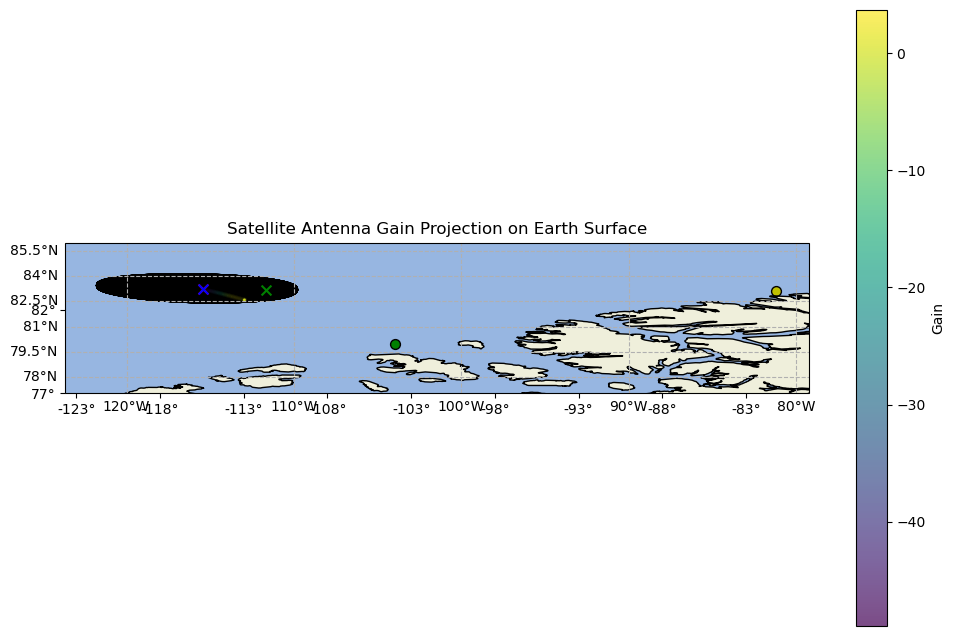

In [31]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Create a figure with Cartopy
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Scatter plot of intersection points with gain as color
sc = ax.scatter(lon, lat, c=reduced_gain_array.flatten(), cmap='viridis', marker='o', s=10, edgecolor='k', alpha=0.7, transform=ccrs.PlateCarree())

# Add boresight location
ax.scatter(lon[0], lat[0], c='r', marker='x', s=50, edgecolor='k', transform=ccrs.PlateCarree())

# Plot location of max gain
max_gain_index = np.argmax(reduced_gain_array.flatten())
ax.scatter(lon[max_gain_index], lat[max_gain_index], c='g', marker='x', s=50, edgecolor='k', transform=ccrs.PlateCarree())

# Do the same for the minimum gain
min_gain_index = np.argmin(reduced_gain_array)
ax.scatter(lon[min_gain_index], lat[min_gain_index], c='b', marker='x', s=50, edgecolor='k', transform=ccrs.PlateCarree())

# Plot the boresight location from the l1b file (tb_lon[0,0], tb_lat[0,0]
l1b_lon = tb_lon[0,0]
l1b_lat = tb_lat[0,0]
ax.scatter(l1b_lon, l1b_lat, c='y', marker='o', s=50, edgecolor='k', transform=ccrs.PlateCarree())

#plot nadir
ax.scatter(sc_nadir_lon[0], sc_nadir_lat[0], c='g', marker='o', s=50, edgecolor='k', transform=ccrs.PlateCarree())


plt.colorbar(sc, label='Gain')
# Define the margin
margin = 2

# Combine all longitude and latitude points for margin calculation
all_lon = np.concatenate((lon, [tb_lon[0, 0], sc_nadir_lon[0]]))
all_lat = np.concatenate((lat, [tb_lat[0, 0], sc_nadir_lat[0]]))

# Set the limits and ticks of the axes
ax.set_xlim(min(all_lon) - margin, max(all_lon) + margin)
ax.set_ylim(min(all_lat) - margin, max(all_lat) + margin)
# Add gridlines with ticks at grid locations
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Manually set ticks to align with gridlines
xticks = np.arange(int(min(all_lon)) - margin, int(max(all_lon)) + margin + 1, 5)
yticks = np.arange(int(min(all_lat)) - margin, int(max(all_lat)) + margin + 1, 5)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())

# Format ticks
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

# Set title
plt.title('Satellite Antenna Gain Projection on Earth Surface')

# Show the plot
plt.show()


# Plot the boresight locations of your projection and the l1b file boresigh location
# print(f"Our Boresight Location is at lon, lat = ({lon[0]},{lat[0]})")
# print(f"SMAP L1b Boresight Location is at lon, lat = ({tb_lon[0,0]},{tb_lat[0,0]})")

# **Some Final Thoughts**

As you can see the boresight locations currently don't allign. Some ideas I still didn't get the chance to try: 

- I haven't included the roll, pitch and yaw values yet. I don't think this will change the result enough for the boresights to align. Nethertheless, it still needs to be implemented.
- As the coordinate systems and rotation matricies are quite complicated and all in different orientations, it is likely that I have messed up on of the transformations.
- It could be that the positional information provided in the L1b file is not the position to the SC frame, but maybe the SRF or some other frame.
- I think the general method is correct and the antenna pattern looks as it should, so I think we can move forward, with this problem remaining as "to be fixed"